In [1]:
import numpy as np
import scipy as sp
from scipy import optimize,special,integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
lam0 = model_problem_spectrum(1000,.8,5e3)
lam1 = model_problem_spectrum(1000,1,1e2)

lams = [lam0,lam1]

mss = [[60,10,20,30,38,43],
       [150,7,10,15,30,80]]

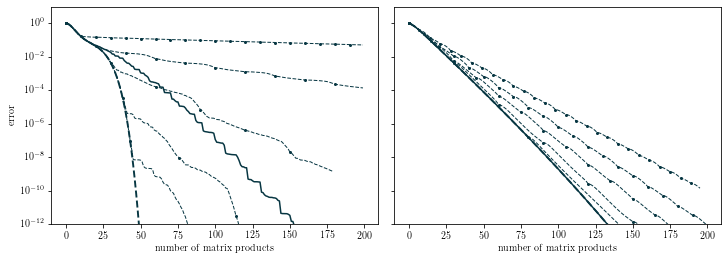

In [4]:
fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True)
fig.subplots_adjust(wspace=.05,hspace=.05)

for trial_idx,lam in enumerate(lams):
    
    A_mat = lam

    n = len(A_mat)

    b_vec = np.ones(n,dtype=np.longdouble)
    b_vec /= np.linalg.norm(b_vec)

    K = 200
    Q_fp,(a_fp_,b_fp_) = exact_lanczos(A_mat,b_vec,K,reorth=False)
    
    e0 = np.zeros(K)
    e0[0] = 1

    error_fp = np.full(K,np.nan)
    error_fp[0]=np.linalg.norm((1/A_mat)*b_vec )
    for i in range(1,K):
        xi = Q_fp[:,:i]@sp.linalg.solve(np.diag(a_fp_[:i])+np.diag(b_fp_[:i-1],1),e0[:i],sym_pos=True)
        error_fp[i] = np.linalg.norm((1/A_mat)*b_vec - xi)
        
    x = (1/A_mat)*b_vec+np.random.randn(n)
    r = b_vec - A_mat*x
    
    ms = mss[trial_idx]
    
    error_restart = {}
    for m in ms:
        error_restart[m] = np.full(K,np.inf)

        e0 = np.zeros(m)
        e0[0] = 1

        x = np.zeros(n)
        for k in range(K//m):
            r = b_vec - A_mat*x
            Q,(a_,b_) = exact_lanczos(A_mat,r,m,reorth=True)

            error_restart[m][k*m] = np.linalg.norm((1/A_mat)*b_vec - x)
            for i in range(1,m):
                xi = x + np.linalg.norm(r)*Q[:,:i]@sp.linalg.solve(np.diag(a_[:i])+np.diag(b_[:i-1],1),e0[:i],sym_pos=True)
                error_restart[m][k*m+i] = np.linalg.norm((1/A_mat)*b_vec - xi)

            x += np.linalg.norm(r)*Q@sp.linalg.solve(np.diag(a_)+np.diag(b_[:-1],1),e0,sym_pos=True)
            
            
    #plt.plot(error/error[0],color='#073642',lw=1,label='exact CG')
    axs[trial_idx].plot(error_fp/error_fp[0],color='#073642',label='finite prec. CG')

    axs[trial_idx].plot(error_restart[ms[0]]/error_fp[0],ls='--',lw=1.9,color='#073642')
    for m in ms[1:]:
        axs[trial_idx].plot(error_restart[m]/error_fp[0],ls='--',lw=1,color='#073642')
        axs[trial_idx].plot(np.arange(0,K,m),error_restart[m][::m]/error_fp[0],marker='o',ms=2,ls='None',color='#073642')

    axs[trial_idx].set_xlabel('number of matrix products')

plt.ylim(1e-12,1e1)
axs[0].set_ylabel('error')

plt.yscale('log')
plt.savefig('imgs/restarted_CG.pdf',bbox_inches='tight')

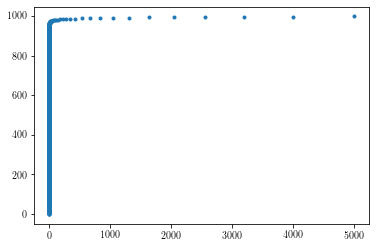

In [5]:
plt.plot(lam0,np.arange(len(lam0)),linestyle='None',marker='.')